In [3]:
%matplotlib inline

%load_ext autoreload
%autoreload 2

import matplotlib
import matplotlib.pyplot as plt
from imageio import imread, imwrite
import pickle
import numpy as np
import tensorflow as tf
import keras
from keras.models import load_model
import keras.backend as K
from scipy.spatial.distance import cosine
import timeit
import falconn

from lib.lib_knn import *
from lib.knn_attack import *

import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

config = tf.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.Session(config=config)
from keras.backend.tensorflow_backend import set_session
set_session(sess)

np.random.seed(1234)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
from keras.datasets import mnist

(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train = X_train[:, :, :, np.newaxis].astype(np.float32) / 255.
X_test = X_test[:, :, :, np.newaxis].astype(np.float32) / 255.
X_train_nm = X_train/np.sqrt(np.sum(X_train**2, axis=(1, 2, 3), keepdims=True))
X_test_nm = X_test/np.sqrt(np.sum(X_test**2, axis=(1, 2, 3), keepdims=True))
X_train_nm = X_train_nm.reshape(-1, 784)
X_test_nm = X_test_nm.reshape(-1, 784)

print("Loading model...")
model, rep_ts = load_mnist_model()

# Randomly chosen calibrate set 75 samples from each class
ind_cal = np.zeros((750, ), dtype=np.int32)
for i in range(10):
    ind = np.where(y_test == i)[0]
    np.random.shuffle(ind)
    ind_cal[i*75 : (i + 1)*75] = ind[:75]
ind_test = np.arange(len(X_test), dtype=np.int32)
ind_test = np.setdiff1d(ind_test, ind_cal)

X_test = X_test[ind_test]
X_test_nm = X_test_nm[ind_test]
y_test = y_test[ind_test]

print("Getting representations...")
rep_train_nm = get_all_rep_nm(sess, X_train, rep_ts)

print("Setting up LSH...")
query = []
for rep in rep_train_nm:
    query.append(setup_lsh(rep, 100))
A = pickle.load(open("A_cosine_lsh.p", "rb"))

11493376/11490434 [==============================] - 2s 0us/step
Loading model...
Getting representations...
Setting up LSH...


In [5]:
from cleverhans.utils_keras import KerasModelWrapper
from cleverhans.utils import set_log_level
import logging


def generate_batch(attack, params, x_org, batch_size=100):
    
    n_org = len(x_org)
    x_adv = np.zeros_like(x_org)
    
    for batch in range(n_org//batch_size):
        begin = batch*batch_size
        end = (batch + 1)*batch_size
        x_adv[begin:end] = attack.generate_np(x_org[begin:end], **params)
        
    return x_adv


tf.set_random_seed(2019)
tf.keras.backend.set_learning_phase(0)
set_log_level(logging.INFO)

wrap = KerasModelWrapper(model)

In [24]:
from cleverhans.attacks import MadryEtAl

pgd = MadryEtAl(wrap, sess=sess)
pgd_params = {'eps': 0.2, 
              'eps_iter': 0.02, 
              'nb_iter': 100, 
              'clip_min': 0., 
              'clip_max': 1., 
              'rand_init': True}
x_pgd = generate_batch(pgd, pgd_params, X_test)

[INFO 2019-02-09 09:16:34,467 cleverhans] Constructing new graph for attack MadryEtAl


In [25]:
model.evaluate(x_pgd, y_test)

9250/9250 [==============================] - 1s 74us/step


[15.231138986020476, 0.0073513513513513516]

In [31]:
np.min(X_test - x_pgd)

-0.20000002

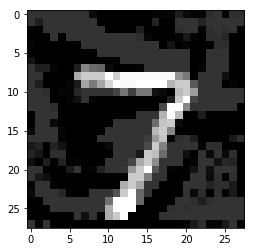

In [29]:
plt.imshow(x_pgd[0, :, :, 0], cmap='gray')
plt.show()

In [5]:
from cleverhans.attacks import CarliniWagnerL2

cw = CarliniWagnerL2(wrap, sess=sess)
cw_params = {'batch_size': 250, 
             'learning_rate': 0.005,
             'binary_search_steps': 5, 
             'max_iterations': 1000, 
             'initial_const': 0.01,
             'abort_early': True,
             'clip_min': 0., 
             'clip_max': 1.}
x_adv = cw.generate_np(X_test, **cw_params)

[INFO 2019-02-12 08:37:31,993 cleverhans] Constructing new graph for attack CarliniWagnerL2
/usr/local/lib/python3.5/dist-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.5/dist-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [6]:
model.evaluate(x_adv, y_test)

9250/9250 [==============================] - 1s 89us/step


[0.7059795025490426, 0.006162162162162162]

In [7]:
np.mean(np.sqrt(np.sum((X_test - x_adv)**2, (1, 2, 3))))

1.2745653

In [8]:
np.max(np.abs(X_test - x_adv))

0.86191875

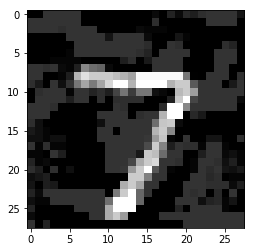

In [32]:
plt.imshow(x_adv[0, :, :, 0], cmap='gray')
plt.show()

In [5]:
min_dist = [0.7484518915597577, 0.742514077896593, 0.5667317128548899, 0.19457440222463473]

In [65]:
# fname = "adv_pn2_pb0_lr0.1_c0.1_m500.p"
# fname = "adv_pn2_pb0_lr0.1_c0.5_m75.p"
# fname = "adv_pninf_pb0.1_lr0.5_c1_m75.p"
# fname = "adv_pninf_pb0.2_lr0.5_c1_m75.p"
# fname = "adv_pninf_pb0.25_lr0.5_c1_m75.p"
# fname = "adv_pninf_pb0.3_lr0.1_c0.5_m75.p"
# fname = "baseline_adv_pninf_pb0.3_lr0.1_c0.5_m75.p"
# fname = "baseline_adv_pninf_pb0.2_lr0.01_c100.0_m75.p"
# fname = "baseline_adv_pn2_pb0_lr0.01_c100.0_m75.p"
# fname = "knn_adv_pninf_pb0.2_lr0.1_c10.0_m75.p"
# fname = "knn_adv_pninf_pb0.3_lr0.1_c10.0_m75.p"
# fname = "knn_adv_pn2_pb0_lr0.1_c10.0_m75.p"
# fname = "cred_adv_pninf_pb0.2_lr0.1_c1_m500.p"
# fname = "dknn_mean.p"
# fanme = "knn_naive_adv.p"
# fname = "adv_pn2_pb3.476_lr0.1_c1e-05_m500.p"
# fname = "adv_pn2_pb3.476_lr0.1_c100.0_m500.p"
fname = "baseline_adv_pn2_pb3.476_lr0.01_c0.1_m75.p"


X_adv = pickle.load(open(fname, "rb"))

In [66]:
X_adv = X_adv.reshape(-1, 28, 28, 1)

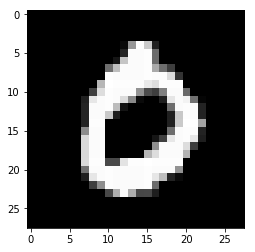

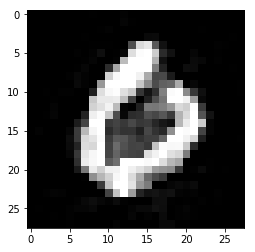

3.453516


In [67]:
i = 3
plt.imshow(X_test[i,:,:,0], cmap='gray')
plt.show()
plt.imshow(X_adv[i,:,:,0], cmap='gray')
plt.show()
print(np.sqrt(np.sum((X_adv[i] - X_test[i])**2)))

In [68]:
zero_ind = np.sum(X_adv, (1, 2, 3)) != 0

In [69]:
np.sum(zero_ind)

9250

In [70]:
np.mean(np.sqrt(np.sum((X_adv[zero_ind] - X_test[zero_ind])**2, (1,2,3))) < 3.476)

0.9096216216216216

(array([2.000e+00, 2.000e+00, 3.000e+00, 2.000e+01, 4.000e+01, 5.200e+01,
        1.160e+02, 3.140e+02, 1.962e+03, 6.739e+03]),
 array([2.770694 , 2.843907 , 2.9171202, 2.9903336, 3.0635467, 3.1367598,
        3.2099729, 3.283186 , 3.3563993, 3.4296124, 3.5028255],
       dtype=float32),
 <a list of 10 Patch objects>)

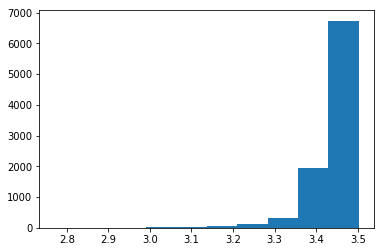

In [71]:
plt.hist(np.sqrt(np.sum((X_adv[zero_ind] - X_test[zero_ind])**2, (1,2,3))))

In [72]:
np.sqrt(np.sum((X_adv - X_test)**2, (1,2,3))).mean()

3.4339468

In [73]:
y_pred = model.predict(X_adv)

In [74]:
rep_adv = get_all_rep_nm(sess, X_adv, rep_ts)

In [75]:
np.mean(np.argmax(y_pred, 1) == y_test)

0.33956756756756756

In [82]:
p, acc = dknn_acc(A, rep_adv, y_test, query, y_train)

In [83]:
acc

0.5004324324324324

In [84]:
np.mean((np.argmax(p, 1) == np.argmax(y_pred, 1)) & (np.argmax(p, 1) != y_test))

0.4648648648648649

In [85]:
1 - np.mean((np.argmax(p, 1) != y_test) & (np.sum(X_adv, (1,2,3)) != 0))

0.5004324324324324

In [86]:
ind_adv = (np.argmax(p, 1) != y_test) & (np.sum(X_adv, (1,2,3)) != 0)

In [87]:
p_adv = np.max(p[ind_adv], axis=1)
p_mean = np.mean(p_adv)
print(p_mean)

0.13850883647118226


In [89]:
print(np.sqrt(np.sum((X_adv[ind_adv] - X_test[ind_adv])**2, (1, 2, 3))).mean())

3.435507


In [28]:
# pickle.dump(p_adv, open("p_dknn_0.2.p", "wb"))
# pickle.dump(p_adv, open("p_dknn_0.25.p", "wb"))
# pickle.dump(p_adv, open("p_dknn_0.3.p", "wb"))
# pickle.dump(p, open("p_dknn_clean.p", "wb"))

p_20 = pickle.load(open("p_dknn_0.2.p", "rb"))
p_25 = pickle.load(open("p_dknn_0.25.p", "rb"))
p_30 = pickle.load(open("p_dknn_0.3.p", "rb"))
p_clean = pickle.load(open("p_dknn_clean.p", "rb"))

In [356]:
dist = np.sqrt(np.sum((X_adv - X_test)**2, axis=(1,2,3)))
np.mean(dist)

6.7149773

In [352]:
dist = np.sqrt(np.sum((X_adv - X_test)**2, axis=(1,2,3)))[ind_adv]
np.mean(dist)

7.2917414

Mean Cred  
0.05 0.0681  
0.1  0.0707  
0.15 0.0790   
0.2  0.1037   
0.25 0.1502  
0.3  0.1809   
0.35 0.2983  
0.4  0.3750  
 
Mean acc  
0.05 0.9614  
0.1  0.8415 
0.15 0.5324  
0.2  0.1744   
0.25 0.0210  
0.3  0   
0.35 0  
0.4  0  

Baseline  
Mean Cred  
0.0531, 0.0644, 0.0727, 0.0807, 0.0883, 0.1053, 0.1235, 0.1383  
Mean Acc  
0.9827, 0.9702, 0.9414, 0.8891, 0.7929, 0.6831, 0.5671, 0.4611

In [161]:
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'

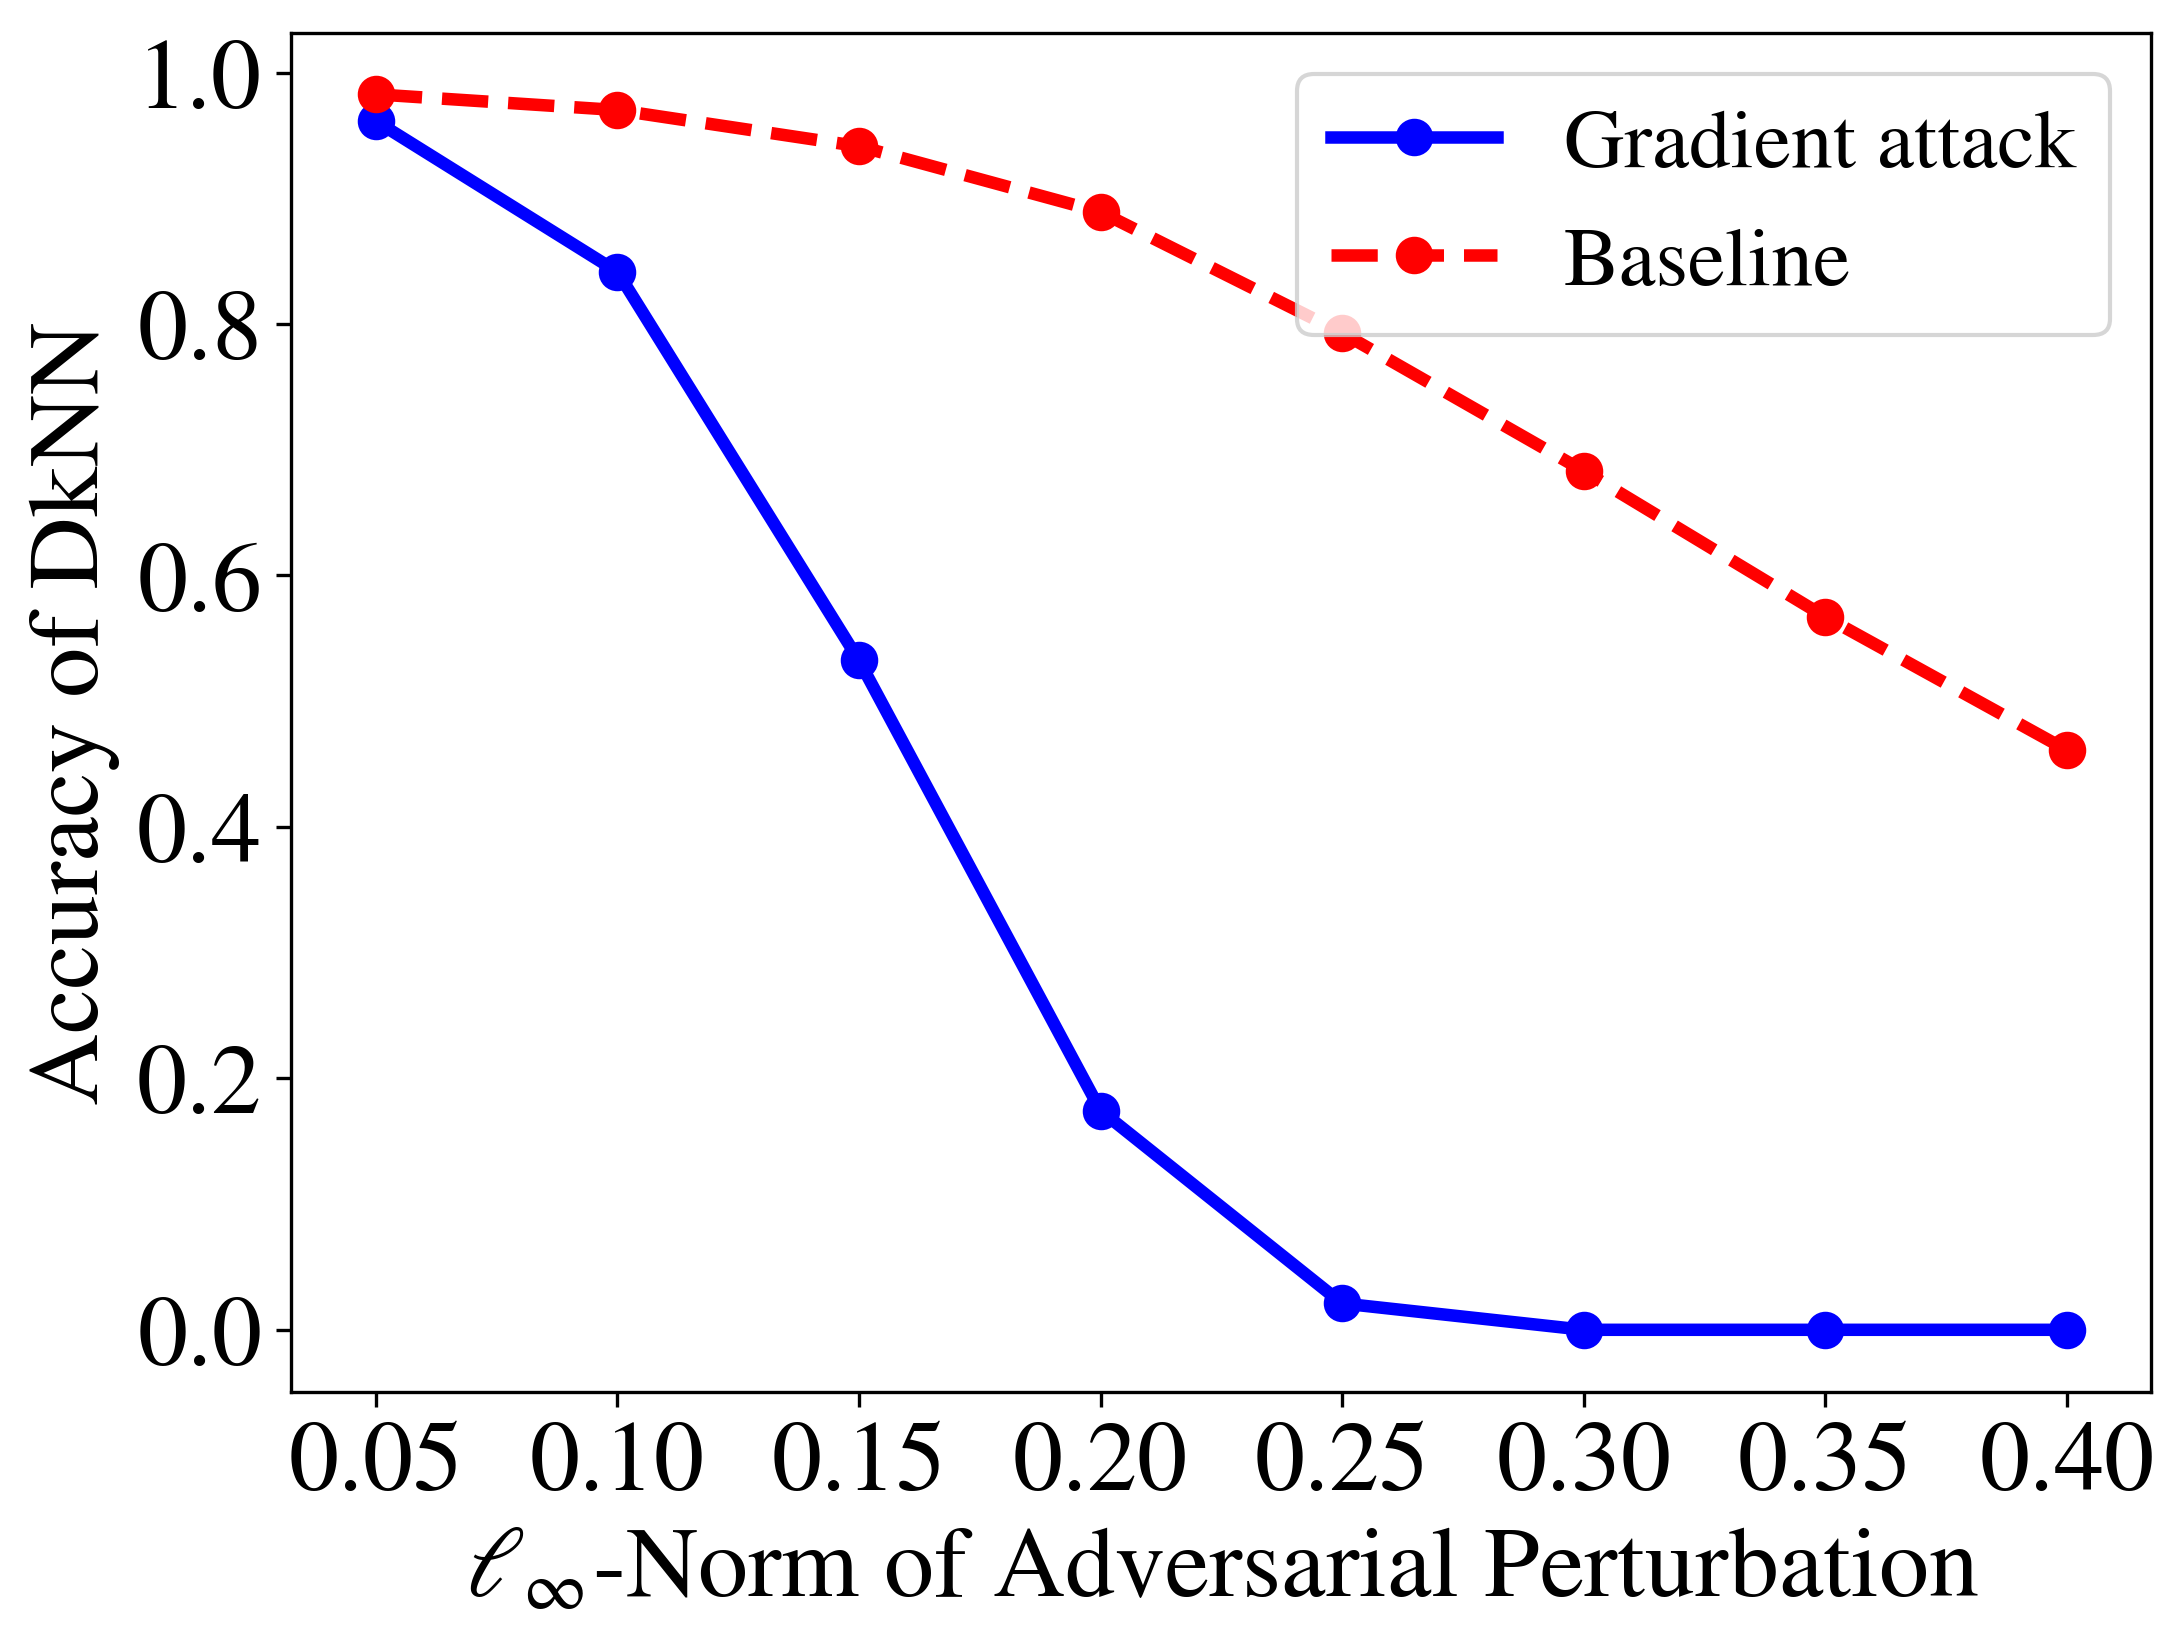

In [167]:
plt.figure(figsize=(8, 6), dpi=300)
eps = np.array([0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4])
acc = np.array([0.9614, 0.8415, 0.5324, 0.1744, 0.0210, 0, 0, 0])
acc2 = np.array([0.9827, 0.9702, 0.9414, 0.8891, 0.7929, 0.6831, 0.5671, 0.4611])

plt.plot(eps, acc, '-o', linewidth=3, markersize=8, color='blue', label="Gradient attack")
plt.plot(eps, acc2, '--o', linewidth=3, markersize=8, color='red', label="Baseline")

plt.ylabel('Accuracy of DkNN', fontsize=24)
plt.xlabel(r'$\ell_\infty$-Norm of Adversarial Perturbation', fontsize=24)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.legend(fontsize=20)
plt.savefig("dknn_eps_acc.pdf", dpi=300, bbox_inches="tight")
plt.show()

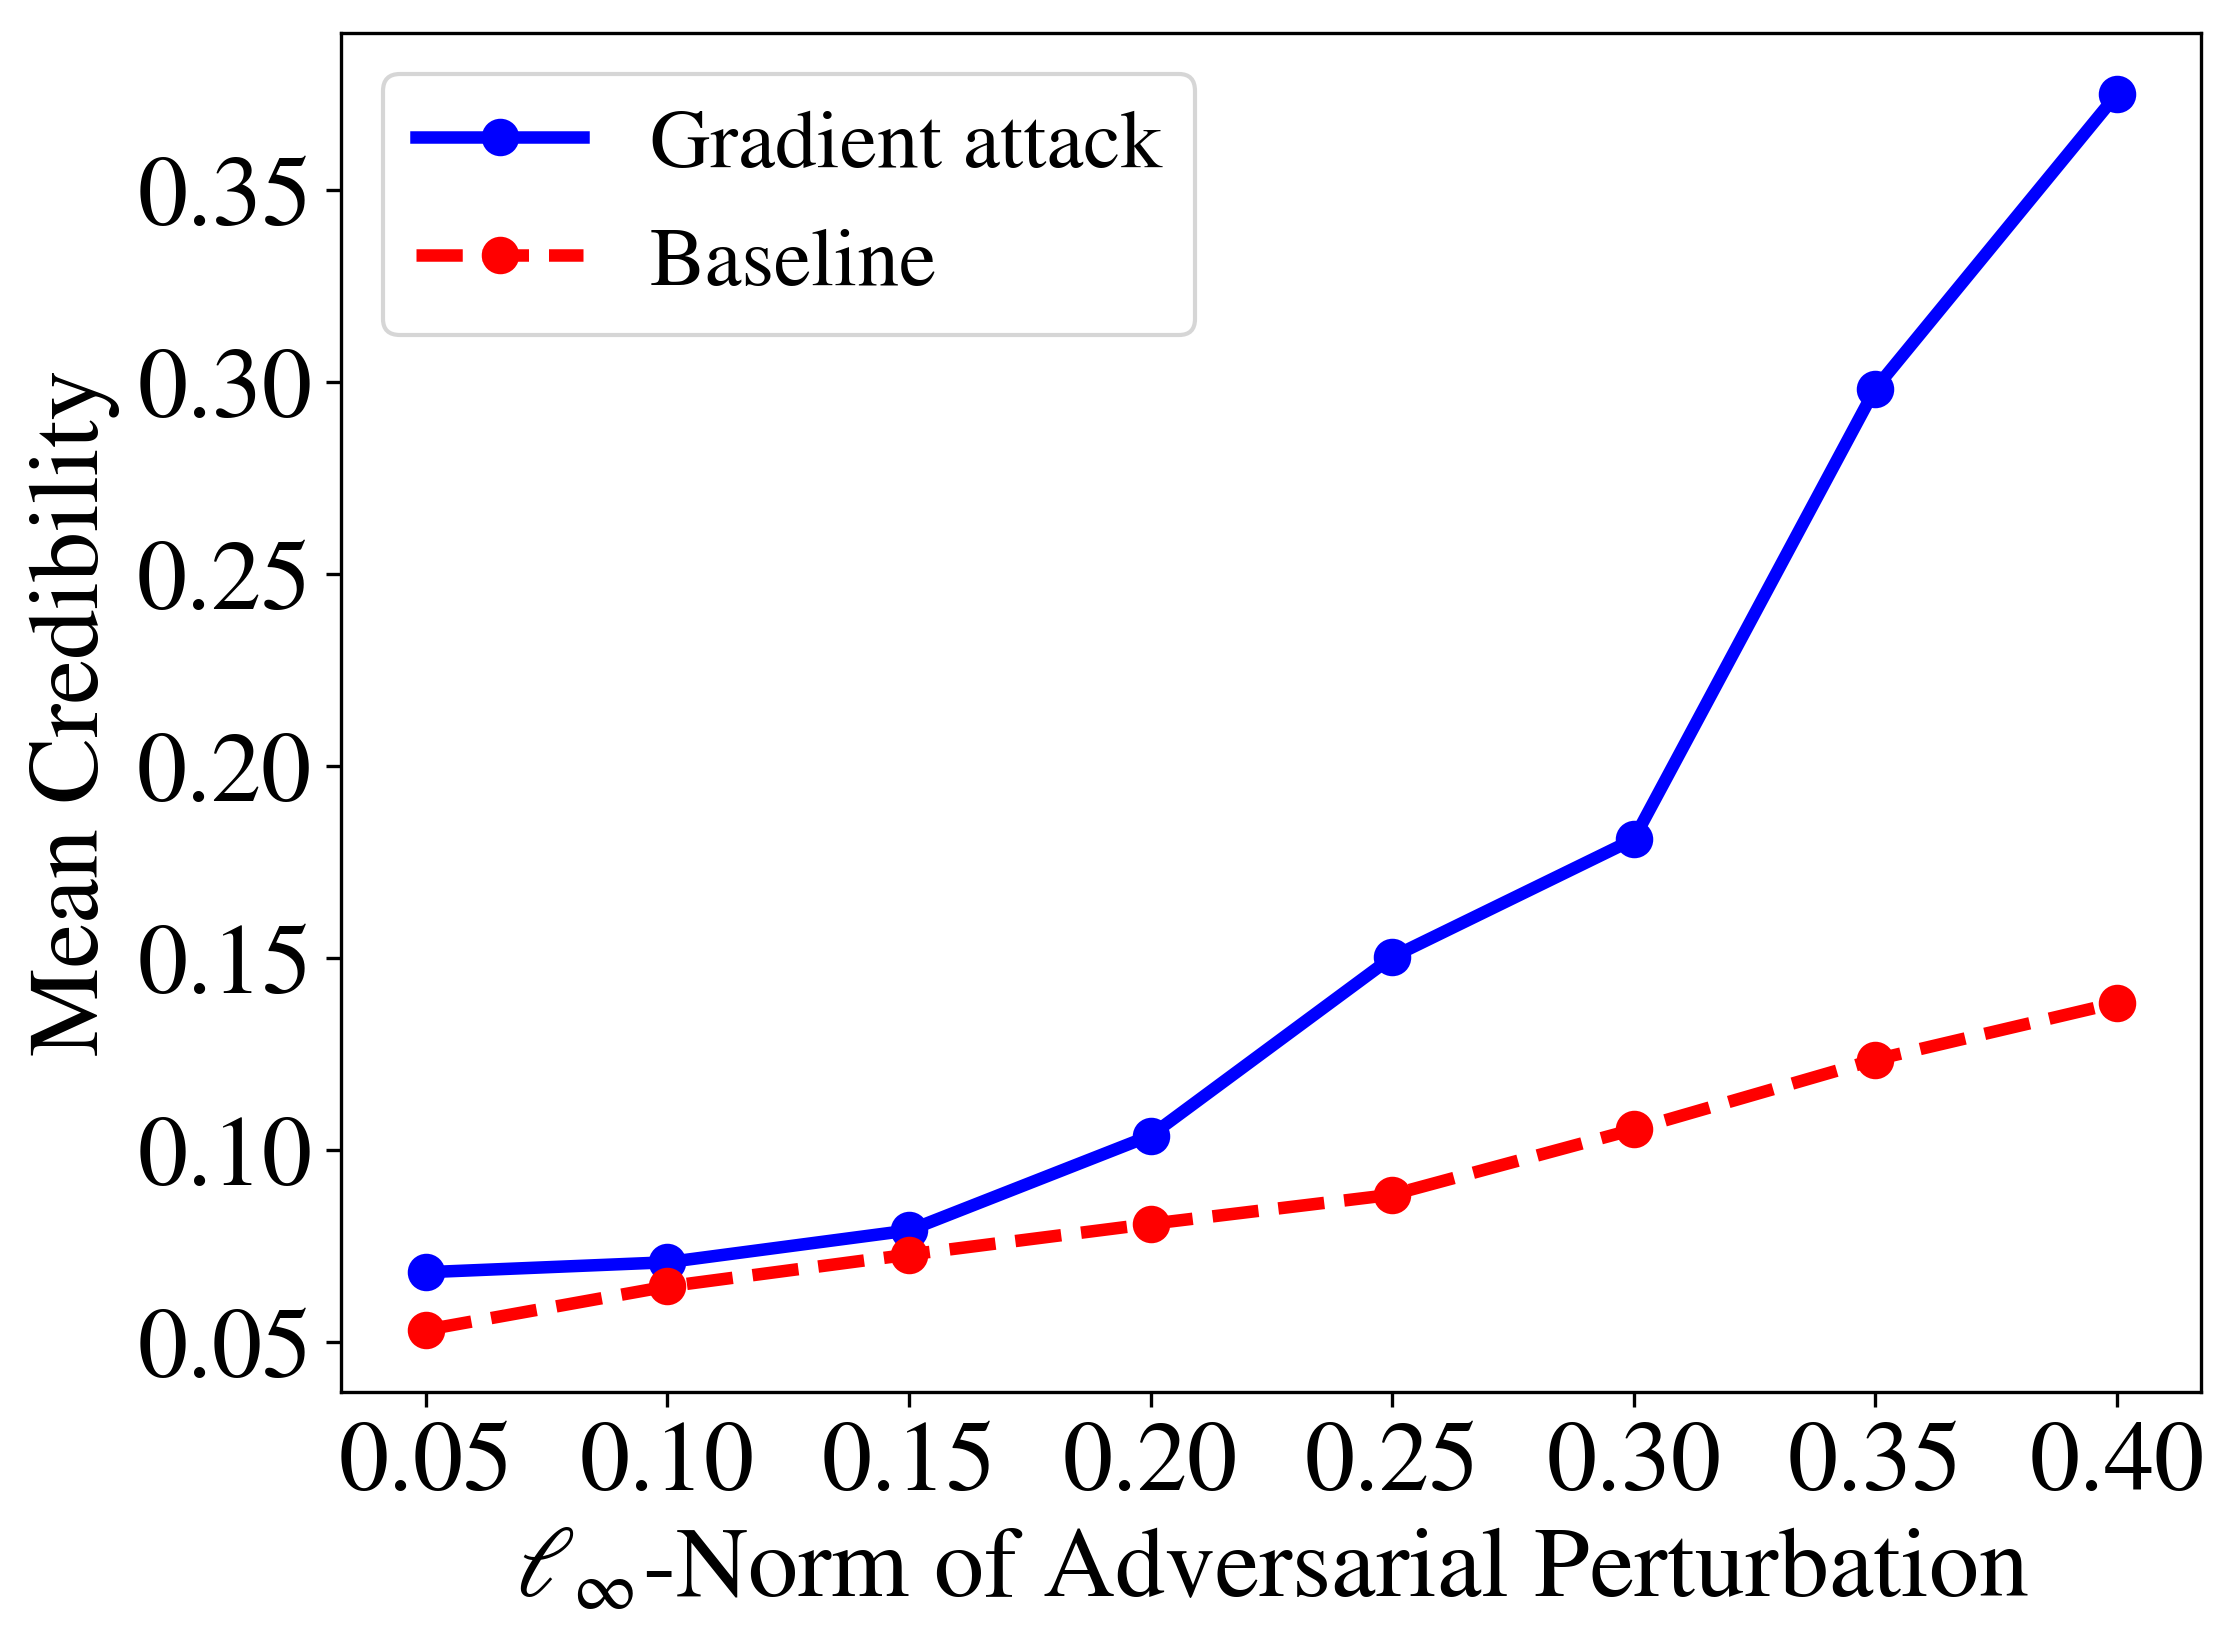

In [383]:
plt.figure(figsize=(8, 6), dpi=300)
eps = np.array([0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4])
cred = np.array([0.0681, 0.0707, 0.0790, 0.1037, 0.1502, 0.1809, 0.2983, 0.3750])
cred2 = np.array([0.0531, 0.0644, 0.0727, 0.0807, 0.0883, 0.1053, 0.1235, 0.1383])

plt.plot(eps, cred, '-o', linewidth=3, markersize=8, color='blue', label="Gradient attack")
plt.plot(eps, cred2, '--o', linewidth=3, markersize=8, color='red', label="Baseline")

plt.ylabel('Mean Credibility', fontsize=24)
plt.xlabel(r'$\ell_\infty$-Norm of Adversarial Perturbation', fontsize=24)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.legend(fontsize=20)
plt.savefig("dknn_eps_cred.pdf", dpi=300, bbox_inches="tight")
plt.show()

In [38]:
np.mean(p_20 > 0.1)

0.284311157674175

In [39]:
np.mean(p_25 > 0.1)

0.4337934842628382

In [297]:
np.mean(np.max(p_clean, 1) > 0.1)

0.9128648648648648

In [37]:
np.sum(np.argmax(p_clean, 1)[np.max(p_clean, 1) > 0.1] == y_test[np.max(p_clean, 1) > 0.1]) / len(X_test)

0.9115675675675675

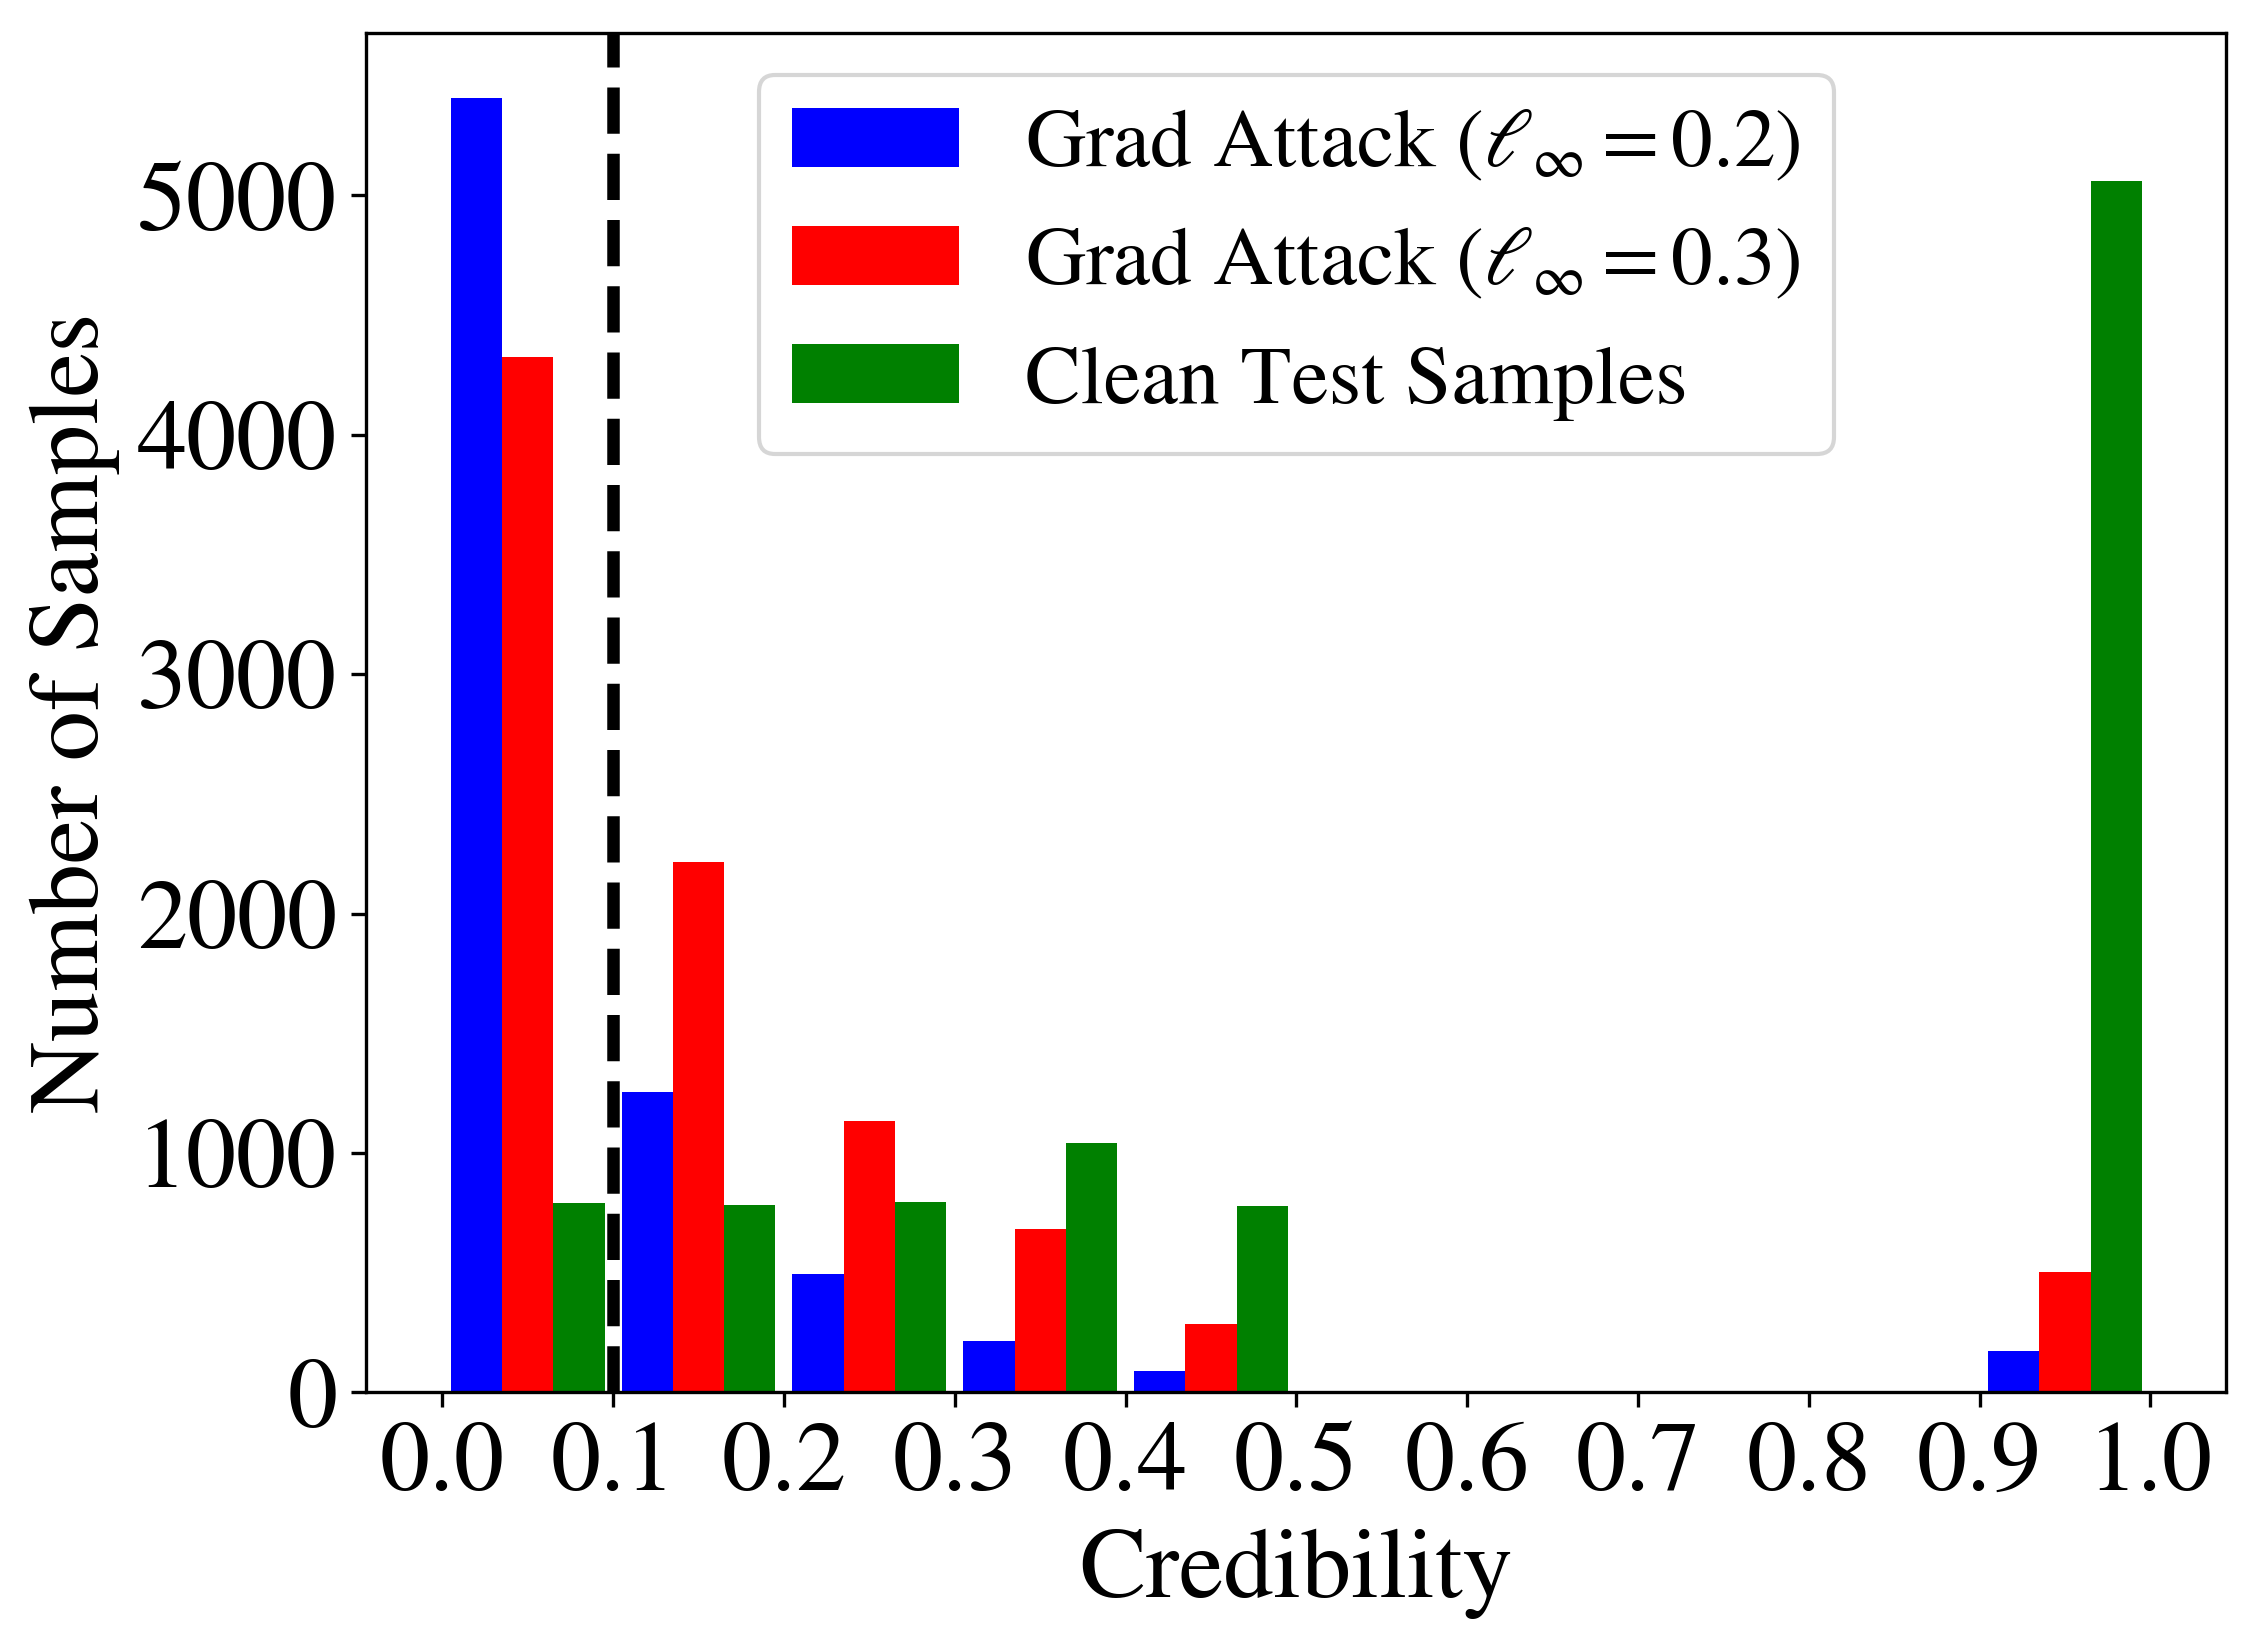

In [170]:
plt.figure(figsize=(8, 6), dpi=300)

# plt.hist(p_20, stacked=False, color='blue', alpha=0.3, rwidth=0.9, label=r'Grad Attack ($\ell_\infty = 0.2$)')
# plt.hist(p_25, stacked=False, color='red', alpha=0.3, rwidth=0.9, label=r'Grad Attack ($\ell_\infty = 0.25$)')
# plt.hist(np.max(p_clean, 1), stacked=False, color='green', alpha=0.3, rwidth=0.9, label="Clean Test Samples")

bins = np.arange(0, 1.1, 0.1)
plt.hist([p_20, p_30, np.max(p_clean, 1)], 
         bins=bins,
         color=['blue', 'red', 'green'], 
         rwidth=0.9, 
         label=[r'Grad Attack ($\ell_\infty = 0.2$)', r'Grad Attack ($\ell_\infty = 0.3$)', "Clean Test Samples"])
plt.axvline(0.1, linestyle='--', color='black', linewidth=3)

plt.ylabel('Number of Samples', fontsize=24)
plt.xlabel('Credibility', fontsize=24)
plt.xticks(np.arange(0, 1.1, 0.1), fontsize=24)
plt.yticks(fontsize=24)
plt.legend(fontsize=20)
plt.savefig("dknn_cred_hist.pdf", dpi=300, bbox_inches="tight")
plt.show()

In [268]:
len(p_25)

9055

In [12]:
for i in np.random.randint(9000, size=10):
    print(np.argmax(p, 1)[i])
    plt.imshow(X_test[i,:,:,0], cmap='gray')
    plt.show()
    plt.imshow(X_adv[i,:,:,0], cmap='gray')
    plt.show()

NameError: name 'p' is not defined

In [ ]:
nn = find_nn(X_adv_nm, X_train_nm, 75)
y_knn = classify(nn, y_train)

In [234]:
X_adv = pickle.load(open("knn_adv_pninf_pb0.2_lr0.1_c10.0_m75.p", "rb"))
for i in np.where(np.sum(X_adv, 1) != 0)[0]:
    print(i)

8
23
32
36
41
42
56
58
60
62
72
75
87
90
92
108
109
111
112
113
116
131
143
161
162
167
175
178
201
203
207
208
209
222
229
233
235
237
238
244
245
247
249
254
256
263
269
277
287
291
294
305
307
308
312
313
318
320
322
325
327
328
335
337
343
344
346
347
359
364
377
384
387
393
401
414
423
424
426
427
428
435
438
442
456
457
460
461
464
470
472
479
481
485
489
492
493
495
504
507
521
522
524
534
540
547
551
552
560
562
572
574
575
579
582
590
594
600
602
609
610
617
622
624
629
636
646
651
653
654
656
661
668
673
675
678
681
687
689
694
699
703
719
730
733
738
740
749
752
753
756
781
783
784
791
792
797
799
809
817
828
832
833
841
848
849
852
872
874
877
878
882
883
885
886
891
894
898
902
904
905
906
907
908
911
920
921
927
935
939
945
954
955
956
976
980
985
989
995
1001
1005
1009
1011
1013
1019
1022
1026
1031
1037
1042
1044
1045
1046
1055
1058
1062
1064
1066
1079
1080
1083
1086
1090
1095
1099
1103
1106
1107
1109
1110
1117
1121
1123
1126
1128
1130
1140
1145
1147
1149
1153
1154
1155


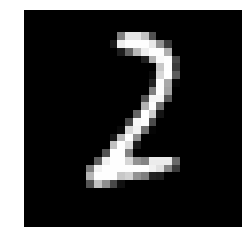

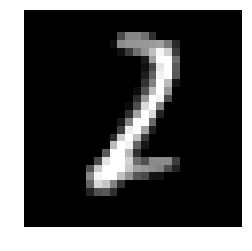

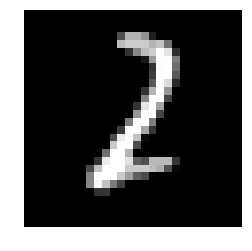

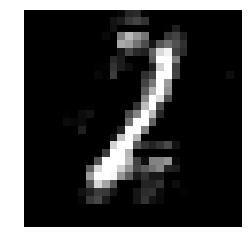

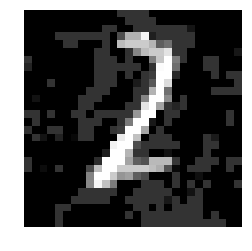

In [306]:
i = 237
# 322 (8), 23 (9), 36 (3), 42, 178 (3), 222 (7), 233 (6), 237 (1)

plt.imshow(X_test[i].reshape(28, 28), cmap='gray')
plt.axis('off')
plt.savefig("test_{}.png".format(i), bbox_inches="tight")
plt.show()

# nn = find_nn(X_test_nm[i:i+1], X_train_nm, 75)
# y_knn = classify(nn, y_train)
# print(y_knn)
    
for j, f in enumerate(["knn_adv_pn2_pb0_lr0.1_c10.0_m75.p", 
                       "knn_adv_pninf_pb0.2_lr0.1_c10.0_m75.p",
                       "adv_pn2_pb0_lr0.1_c0.5_m75.p",
                       "adv_pninf_pb0.2_lr0.5_c1_m75.p"]):

    X_adv = pickle.load(open(f, "rb"))
    
#     if j < 2:
#         x = X_adv[i] / np.linalg.norm(X_adv[i])
#         nn = find_nn(x[np.newaxis], X_train_nm, 75)
#         y_knn = classify(nn, y_train)
#         print(y_knn)
#     else:
#         rep_adv = get_all_rep_nm(sess, X_adv[i:i+1], rep_ts)
#         p, acc = dknn_acc(A, rep_adv, y_test[i:i+1], query, y_train)
#         print(np.argmax(p, 1))
    
    plt.imshow(X_adv[i].reshape(28, 28), cmap='gray')
    plt.axis('off')
    plt.savefig("adv{}_{}.png".format(j, i), bbox_inches="tight")
    plt.show()

In [25]:
dist = np.sqrt(np.sum((X_adv - X_test)**2, axis=(1,2,3)))

In [26]:
np.mean(dist)

3.4982827

(array([ 204.,  618., 2226., 3075., 1830.,  752.,  398.,  125.,   16.,
           6.]),
 array([0.12248089, 0.7337505 , 1.3450202 , 1.9562898 , 2.5675592 ,
        3.178829  , 3.7900987 , 4.401368  , 5.0126376 , 5.6239076 ,
        6.235177  ], dtype=float32),
 <a list of 10 Patch objects>)

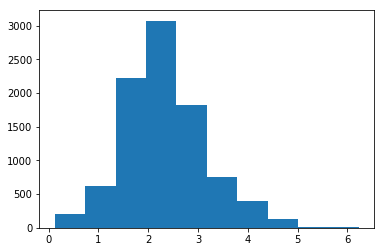

In [29]:
plt.hist(dist)

(array([ 239.,  625., 2210., 3176., 1848.,  713.,  307.,   97.,   21.,
          14.]),
 array([0.10713325, 0.6849565 , 1.2627797 , 1.8406029 , 2.418426  ,
        2.9962494 , 3.5740726 , 4.151896  , 4.729719  , 5.3075423 ,
        5.8853655 ], dtype=float32),
 <a list of 10 Patch objects>)

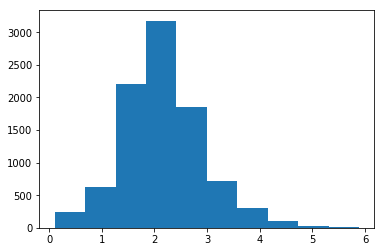

In [24]:
dist = np.sqrt(np.sum((X_adv - X_test)**2, axis=(1,2,3)))
plt.hist(dist)

In [ ]:
for l in range(4):
    nn = query_nn(query[l], rep[l], 75)

In [111]:
for pb in [0.05, 0.1, 0.15, 0.2, 0.25, 0.35, 0.4]:

    print(pb)

#     fname = "adv_pninf_pb{}_lr0.5_c1_m75.p".format(pb)
    fname = "baseline_adv_pninf_pb{}_lr0.01_c100.0_m75.p".format(pb)
    X_adv = pickle.load(open(fname, "rb"))
    
    rep_adv = get_all_rep_nm(sess, X_adv, rep_ts)
    p, acc = dknn_acc(A, rep_adv, y_test, query, y_train)
    print(1 - np.mean((np.argmax(p, 1) != y_test) & (np.sum(X_adv, (1,2,3)) != 0)))
    print(acc)
    
    p_adv = np.max(p[np.argmax(p, 1) != y_test], axis=1)
    p_mean = np.mean(p_adv)
    print(p_mean)

0.05
0.9827027027027027
0.9827027027027027
0.053108333333333334
0.1
0.9702702702702702
0.9702702702702702
0.06444121212121212
0.15
0.9414054054054054
0.9414054054054054
0.07271832718327183
0.2
0.8891891891891892
0.8891891891891892
0.08073365853658536
0.25
0.792972972972973
0.792972972972973
0.08833559617058312
0.35
0.5671351351351351
0.5671351351351351
0.1235780885780886
0.4
0.46118918918918916
0.46118918918918916
0.13837399678972712


## Getting Results

In [59]:
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'

In [96]:
name = "dknn_l2_m500"

In [43]:
# dknn
y_model = np.argmax(model.predict(X_adv), 1)
rep_adv = get_all_rep_nm(sess, X_adv, rep_ts)
p, acc = dknn_acc(A, rep_adv, y_test, query, y_train)
y_adv = np.argmax(p, 1)

In [374]:
# knn
# fname = "knn_adv_pninf_pb0.2_lr0.1_c10.0_m75.p"
# fname = "knn_mean.p"
# fname = "knn_naive_adv.p"
fname = "knn_adv_pn2_pb0_lr0.1_c10.0_m75.p"

X_adv = pickle.load(open(fname, "rb"))
X_adv = X_adv.reshape(-1, 784)

In [380]:
ind = np.where(np.sum(X_adv, axis=1) != 0)[0]
# isnan = np.array([np.any(np.isnan(x)) for x in X_adv])
# ind = np.where(~isnan)[0]

X_adv_nm = X_adv[ind] / np.sqrt(np.sum(X_adv[ind]**2, axis=1, keepdims=True))
nn = find_nn(X_adv_nm, X_train_nm, 75)
y_knn = classify(nn, y_train)

print(np.mean(y_knn == y_test[ind]))

0.06179648806843764


In [381]:
(9250 - len(ind) + np.sum(y_knn == y_test[ind])) / 9250

0.09891891891891892

In [382]:
ind_adv = ind[y_knn != y_test[ind]]
dist = np.sqrt(np.sum((X_adv - X_test.reshape(-1, 784))**2, axis=1))[ind_adv]
np.mean(dist)

6.565501

In [160]:
np.mean(y_adv == y_test)

NameError: name 'y_adv' is not defined

In [52]:
np.mean((y_adv != y_test) & (y_adv == y_model))

0.9500540540540541

In [55]:
suc_ind = np.where((y_adv != y_test) & (y_adv == y_model))[0]
dist = np.sqrt(np.sum((X_adv - X_test)**2, (1, 2, 3)))[suc_ind]
mean_dist = np.mean(dist)
print(mean_dist)

2.3754416


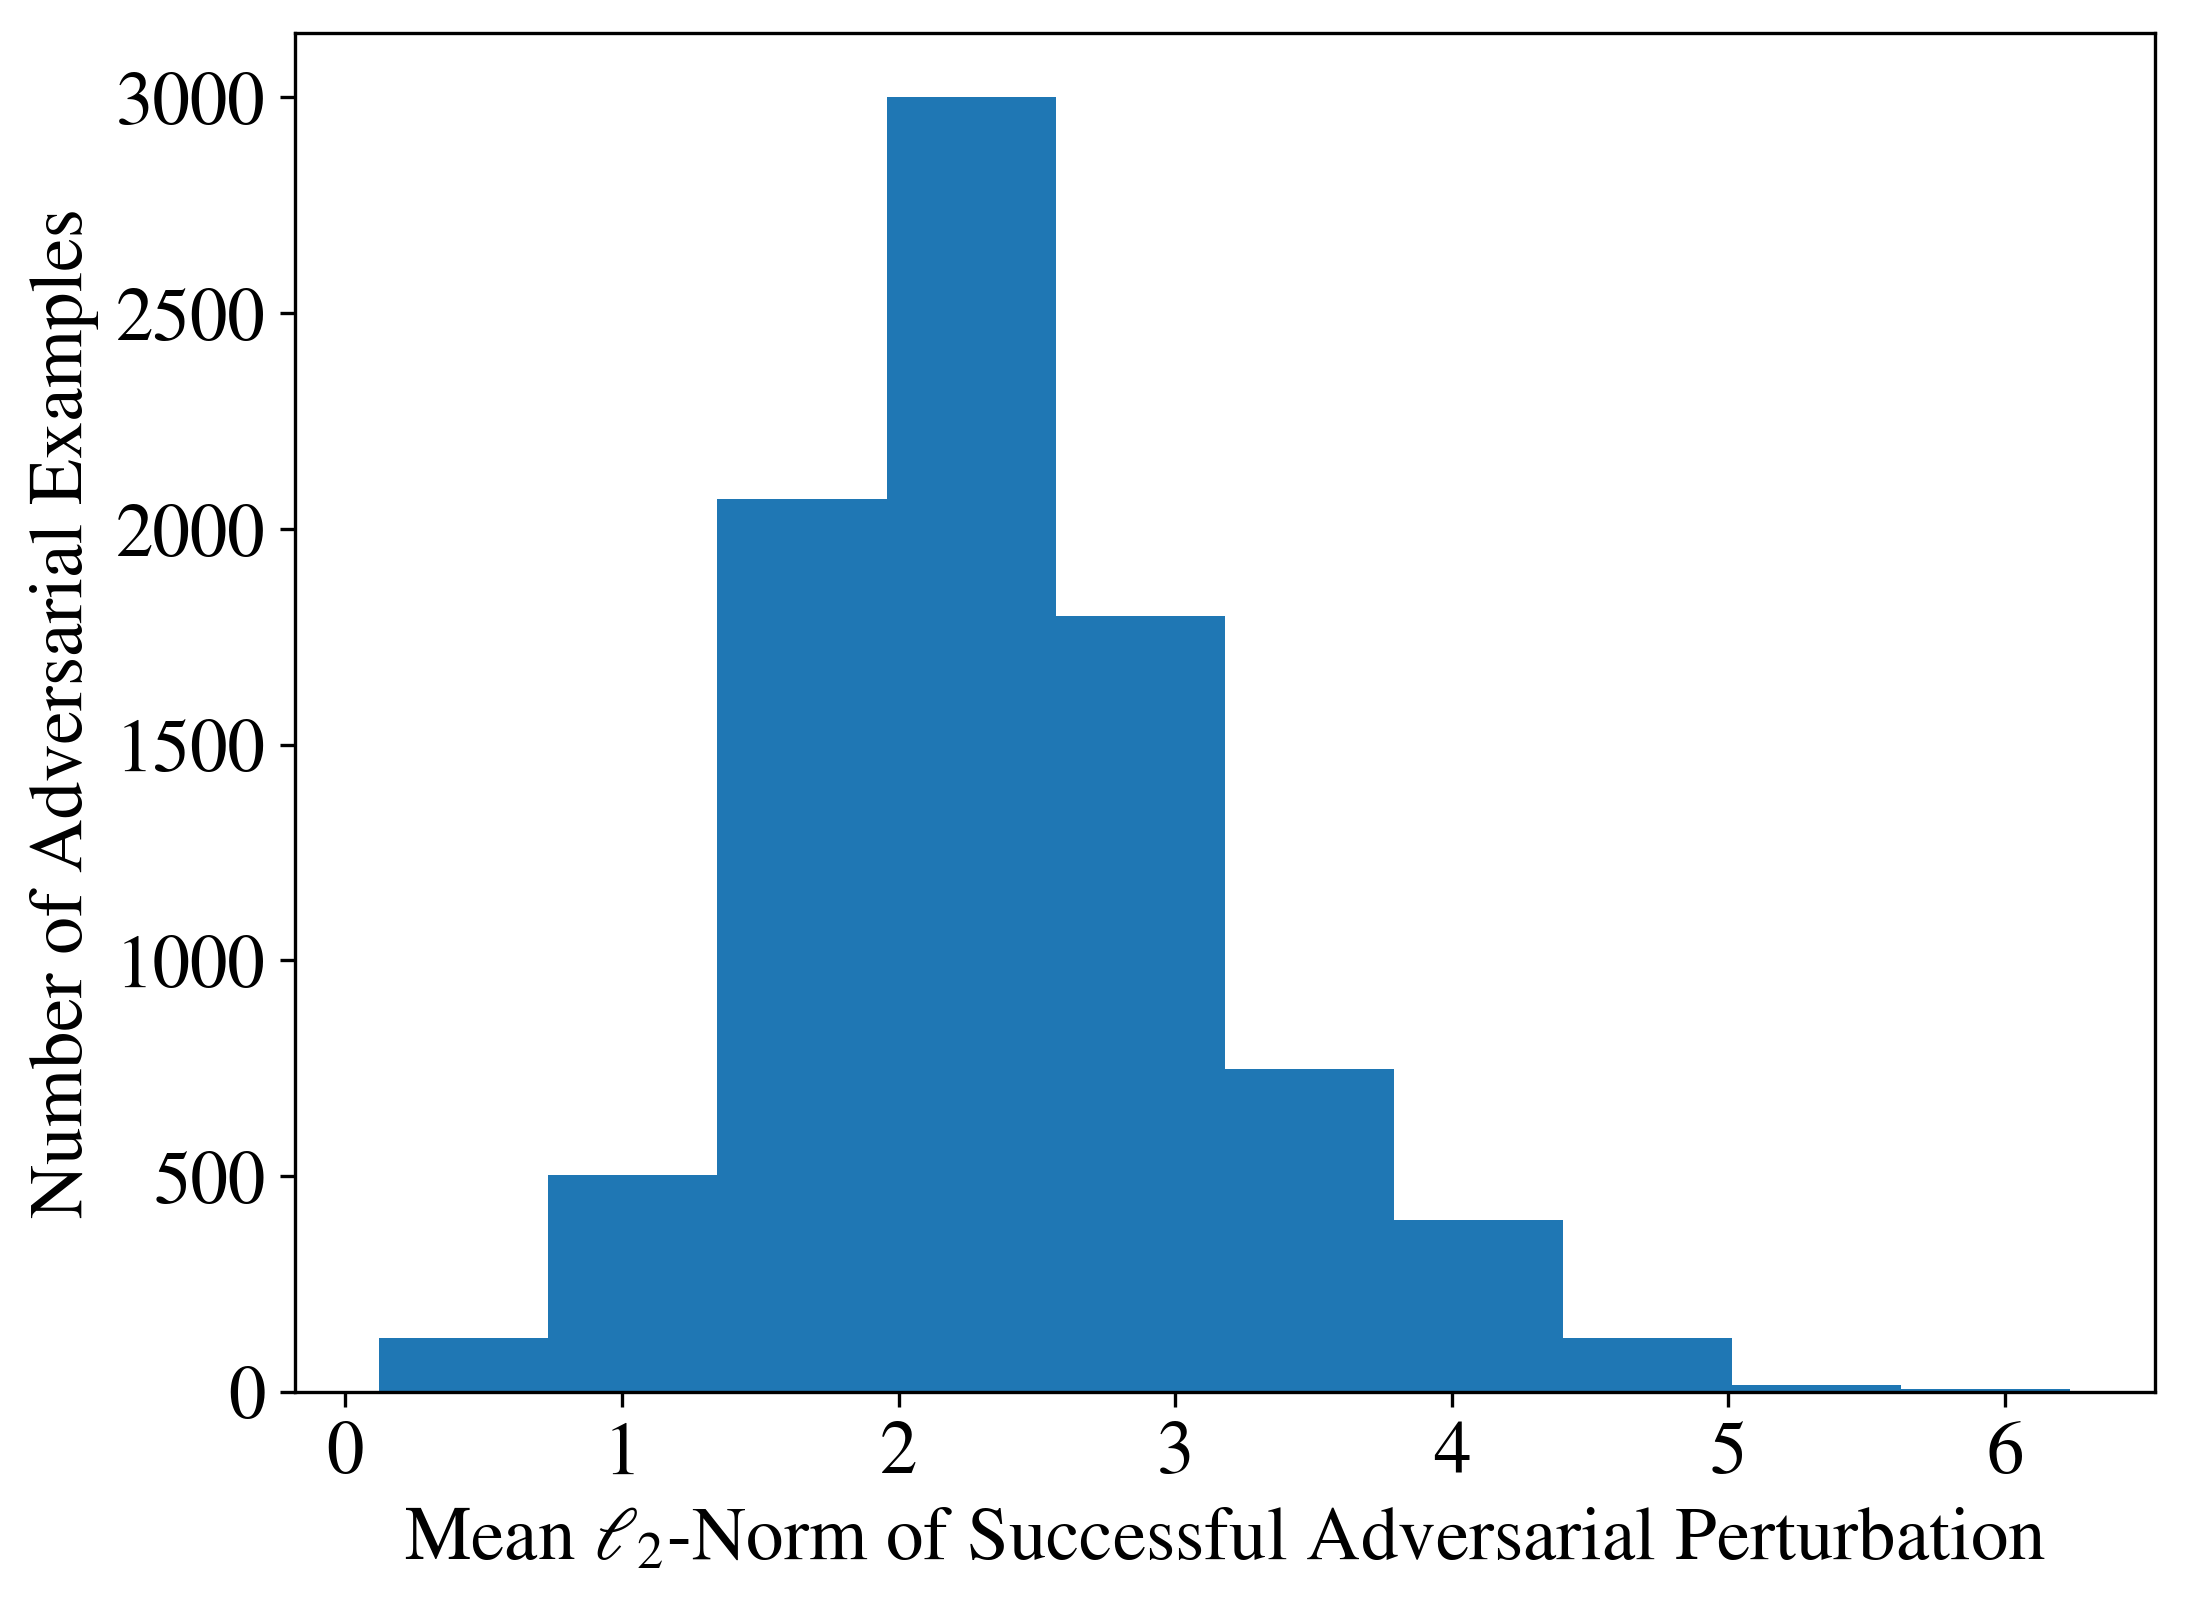

In [104]:
plt.figure(figsize=(8, 6), dpi=300)
plt.hist(dist, color="blue")
plt.xlabel(r'Mean $\ell_2$-Norm of Successful Adversarial Perturbation', fontsize=18)
plt.ylabel('Number of Adversarial Examples', fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.savefig(name + "_dist.pdf", dpi=300, bbox_inches="tight")
plt.show()

5


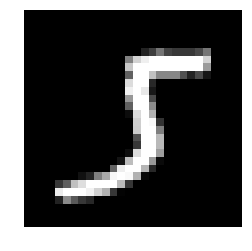

3


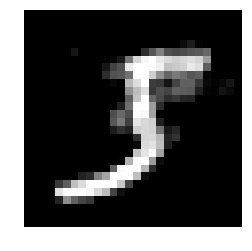

7


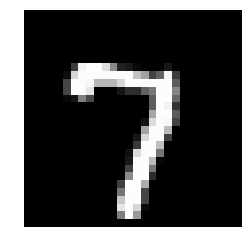

9


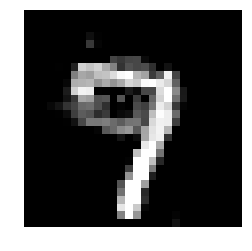

4


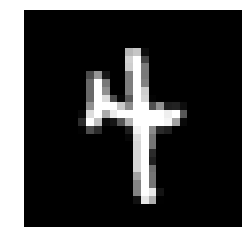

1


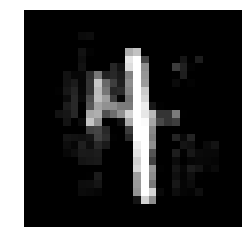

1


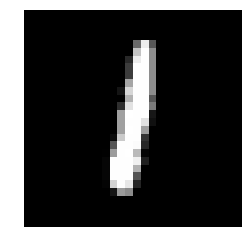

6


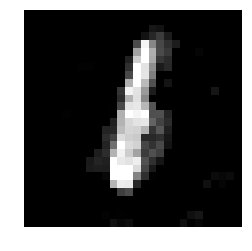

7


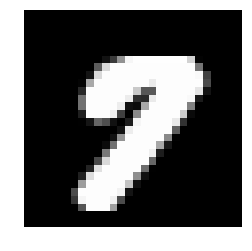

9


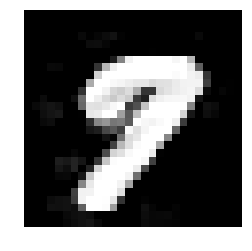

0


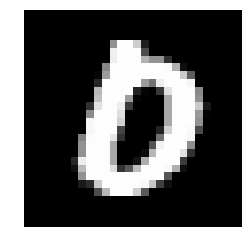

3


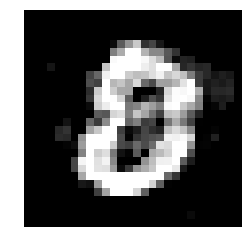

6


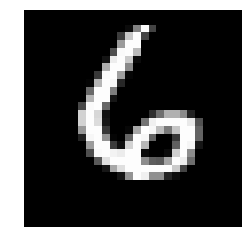

0


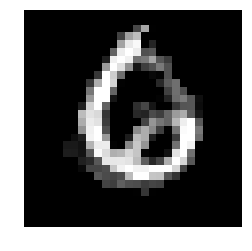

0


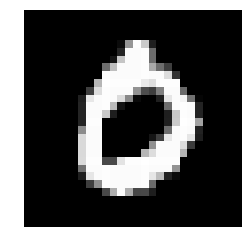

6


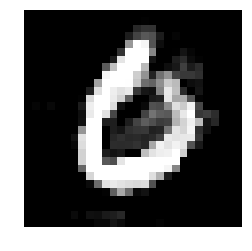

2


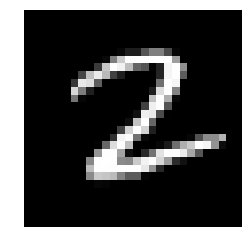

8


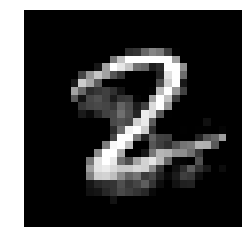

8


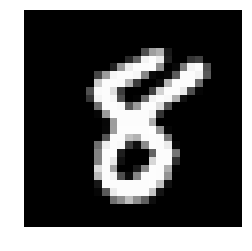

5


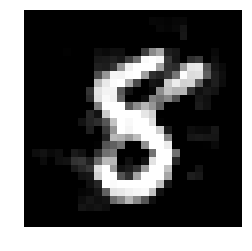

In [105]:
for i in np.random.randint(9000, size=10):
    print(y_test[i])
    plt.imshow(X_test[i,:,:,0], cmap='gray')
    plt.axis('off')
    plt.savefig(name + "_clean_{}.pdf".format(i),
                bbox_inches="tight")
    plt.show()
    print(y_adv[i])
    plt.imshow(X_adv[i,:,:,0], cmap='gray')
    plt.axis('off')
    plt.savefig(name + "_adv_{}_y{}.pdf".format(i, y_adv[i]),
                bbox_inches="tight")
    plt.show()

In [106]:
k = 5
ind = 3

nn_k = []
for l in range(4):
    nn = query_nn(query[l], rep_adv[l][ind : ind + 1], k)
    nn_k.append(X_train[nn][0])

6


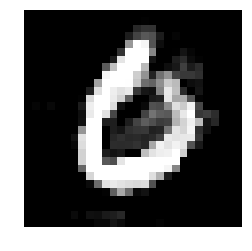

/usr/local/lib/python3.5/dist-packages/matplotlib/figure.py:457: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


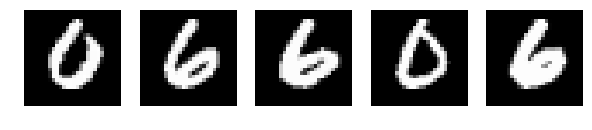

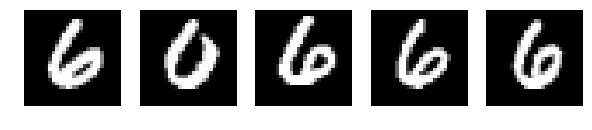

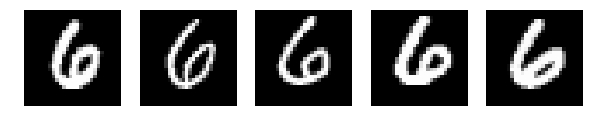

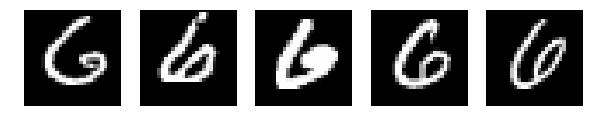

In [107]:
print(y_adv[ind])
plt.imshow(X_adv[ind,:,:,0], cmap='gray')
plt.axis('off')
plt.savefig(name + "_nn_adv_y{}.pdf".format(y_adv[ind]),
            bbox_inches="tight")
plt.show()
    
for l in range(4):
    fig, ax = plt.subplots(1, 5, figsize=(10, 2))
    for j, x in enumerate(nn_k[l]):
        ax[j].imshow(x[:,:,0], cmap='gray')
        ax[j].axis('off')
    fig.savefig(name + "_nn_{}.pdf".format(l),
                bbox_inches="tight")
    fig.show()

In [187]:
# name = "dknn_linf_m75"
# name = "dknn_l2_m75"
# name = "test"
# name = "mean"
# name = "baseline_linf"
name = "baseline_l2"

In [188]:
# X_adv = X_test

In [201]:
rep_adv = get_all_rep_nm(sess, X_adv[20][np.newaxis], rep_ts)

In [202]:
p, acc = dknn_acc(A, rep_adv, y_test, query, y_train)

In [203]:
np.argmax(p, 1)

array([6])

In [204]:
p

array([[0.        , 0.        , 0.        , 0.        , 0.        ,
        0.00533333, 0.01733333, 0.        , 0.        , 0.        ]])

In [192]:
k = 5

nn_k = []
for l in range(4):
    nn = query_nn(query[l], rep_adv[l][0:1], k)
    nn_k.append(X_train[nn][0])

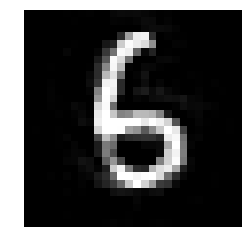

/usr/local/lib/python3.5/dist-packages/matplotlib/figure.py:457: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


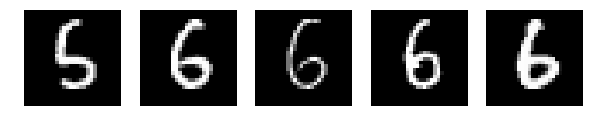

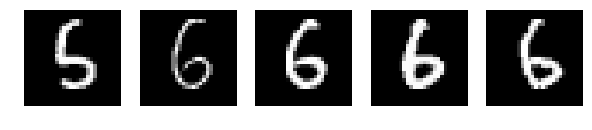

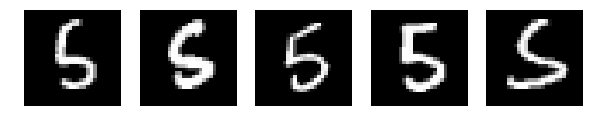

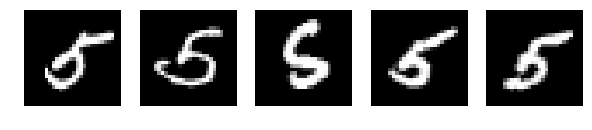

In [193]:
plt.imshow(X_adv[20,:,:,0], cmap='gray')
plt.axis('off')
plt.savefig(name + "_nn_adv.pdf",
            bbox_inches="tight")
plt.show()
    
for l in range(4):
    fig, ax = plt.subplots(1, 5, figsize=(10, 2))
    for j, x in enumerate(nn_k[l]):
        ax[j].imshow(x[:,:,0], cmap='gray')
        ax[j].axis('off')
    fig.savefig(name + "_nn_{}.pdf".format(l),
                bbox_inches="tight")
    fig.show()

In [78]:
x.shape

(5, 28, 28, 1)

In [79]:
nn_k[0].shape

(1, 5, 28, 28, 1)

In [35]:
np.argmax(p)

7

In [42]:
y_train[nn].shape

(9250, 75)

In [40]:
np.argmax(np.array([[1, 2], [3,4], [5,6]]), axis=0)

array([2, 2])

In [66]:
np.mean(np.max(p_clean, 1))

0.6642570090090091

---
# kNN

In [52]:
# fname = "knn_adv_pn2_pb0_lr0.1_c10.0_m75.p"
fname = "knn_adv_pn2_pb0_lr0.1_c10.0_m75.p"

X_adv = pickle.load(open(fname, "rb"))

In [56]:
nn = find_nn(X_adv, X_train.reshape(-1 ,784), 75)
y_pred = classify(nn, y_train)

In [57]:
np.mean(y_pred == y_test)

0.1854054054054054

6.7149773


(array([ 684., 1309., 1343.,  436.,  551., 1384., 1960., 1285.,  278.,
          20.]),
 array([ 0.6862997,  2.0070977,  3.3278959,  4.648694 ,  5.969492 ,
         7.29029  ,  8.611088 ,  9.931887 , 11.252685 , 12.5734825,
        13.89428  ], dtype=float32),
 <a list of 10 Patch objects>)

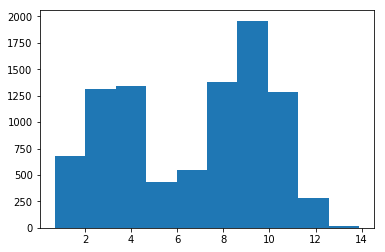

In [54]:
dist = np.sqrt(np.sum((X_adv.reshape(-1, 28, 28, 1) - X_test)**2, axis=(1,2,3)))
print(np.mean(dist))
plt.hist(dist)

In [58]:
dist_l2 = np.copy(dist)

---

## Mean Attack

In [22]:
means = np.zeros((10, 28, 28, 1))

for i in range(10):
    means[i] = np.mean(X_train[y_train == i], axis=0)

In [29]:
def add_mean(X, y, means, eps):
    
    X_adv = np.zeros((9, ) + X.shape)
    
    for i, x in enumerate(X):
        ind = np.arange(10)
        X_adv[:, i] = x + eps*(means[ind != y[i]] - means[y[i]])
    X_adv = np.clip(X_adv, 0, 1)
    
    return X_adv

In [ ]:
rep_adv = get_all_rep_nm(sess, X_adv, rep_ts)
p, acc = dknn_acc(A, rep_adv, y_test, query, y_train)